# Deep Learning for Text - Encoder Models

## Introduction



In the previous module we studied an application of NLP that consisted essentially in classifying text. We saw that bag of words and bigrams (with a bit of help of word embeddings) were very useful for this task. In this module we will focus on a different class of task for which we'll need to develop different models and neural network architectures.

The type of tasks we are thinking about involve:
- "What should be the next word in this incomplete sentence?" (language modeling)
- "What are the components of a sentence?" (Named Entity Recognition)
- "What's the purpose of a query?" (Intent Prediction)
- "What are the key words in query?" (Slot Filing)

In this notebook we will the last two task above. Natural Language Understanding (NLU), the technology behind conversational AI (chatbots, virtual assistant, augmented analytics) typically includes the intent classification and slot filling tasks, aiming to provide a semantic tool for user utterances. Intent classification focuses on predicting the intent of the query, while slot filling extracts semantic concepts in the query. For example the user query could be “Find me an action movie by Steven Spielberg”. The intent here is “find_movie” while the slots are “genre” with value “action” and “directed_by” with value “Steven Spielberg”.

For this module we will use the ATIS dataset which includes queries from people trying to find flight tickets between two destinations. The task will be to read this raw query and understand i) what is the intent of the query (find availability of flight, duration of flight, ground transportation service), and ii) what are components or slots of that query (which airports or cities, what days and time).

## Data Preprocessing



Let's begin extracting the data from the ATIS dataset and turning into a form that we can use in our Deep Learning models.

The ATIS dataset is standard benchmark dataset widely used to build models for intent classification and slot filling tasks (we will explain all this shortly). You can find a very detailed explanation [here](https://catalog.ldc.upenn.edu/docs/LDC93S4B/corpus.html).

We will begin by loading the file and then partitioning into a test and a training set.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42)

In [ ]:
df_train = pd.read_csv('https://www.dropbox.com/s/3pjctskve34qef5/atis_train_data.csv?dl=1')
df_test = pd.read_csv('https://www.dropbox.com/s/pv7uc7ozvdxkncs/atis_test_data.csv?dl=1')

Let's visualize all of this on a dataframe. Below we display an example query for each intent class in a nice layout.

The first column of the Dataframe below contains the actual query that was asked. The second column indicates the intent (flight, flight time, etc), whereas the last column contains the slot filling structure.

In [ ]:
pd.set_option('display.max_colwidth', -1)
df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df_train.intent.unique():
  df_small.loc[j] = df_train[df_train.intent==i].iloc[0]
  j = j+1
  
df_small

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


Let's see how many different types of "intent" are present in the data.

In [ ]:
df_train['intent'].value_counts()

flight                        3666
airfare                       423 
ground_service                255 
airline                       157 
abbreviation                  147 
aircraft                      81  
flight_time                   54  
quantity                      51  
flight+airfare                21  
airport                       20  
distance                      20  
city                          19  
ground_fare                   18  
capacity                      16  
flight_no                     12  
meal                          6   
restriction                   6   
airline+flight_no             2   
ground_service+ground_fare    1   
airfare+flight_time           1   
cheapest                      1   
aircraft+flight+flight_no     1   
Name: intent, dtype: int64

In [ ]:
query_data_train = df_train['query'].values
intent_data_train = df_train['intent'].values
slot_data_train = df_train['slot filling'].values

query_data_test = df_test['query'].values
intent_data_test = df_test['intent'].values
slot_data_test = df_test['slot filling'].values

We briefly mentioned what the difference were between slot filling and intent in the introduction, but is worth going into more detail.

As an example, let’s consider the user query “*i want to fly from boston at 838 am and arrive in denver at 1110 in the morning*”. The model should classify this user query as “**flight**” intent. It should also parse the query, identify and fill all slots necessary for understanding the query. Although the words “I”, “want”, “to”, “fly”, “from”, “at”, “and”, “arrive”, “in”, “the” contribute to understand the context of the intent, the model should correctly label the entities needed to fulfill user’s goal in its intention to take a flight. These are “boston” as departure city (B-fromloc.city), “8:38 am” as departure time (B-depart_time.time), “denver” as destination city (B-toloc.city_name), “11:10” as arrival time (B-arrive_time.time) and “morning” as arrival period of day (B-arrive_time.period_of_day). The 123 slot categories are shown below.

In [ ]:
unique_slots = set()
for s in slot_data_train:
  unique_slots = unique_slots.union(set(s.split()))
unique_slots

{'B-aircraft_code',
 'B-airline_code',
 'B-airline_name',
 'B-airport_code',
 'B-airport_name',
 'B-arrive_date.date_relative',
 'B-arrive_date.day_name',
 'B-arrive_date.day_number',
 'B-arrive_date.month_name',
 'B-arrive_date.today_relative',
 'B-arrive_time.end_time',
 'B-arrive_time.period_mod',
 'B-arrive_time.period_of_day',
 'B-arrive_time.start_time',
 'B-arrive_time.time',
 'B-arrive_time.time_relative',
 'B-city_name',
 'B-class_type',
 'B-connect',
 'B-cost_relative',
 'B-day_name',
 'B-day_number',
 'B-days_code',
 'B-depart_date.date_relative',
 'B-depart_date.day_name',
 'B-depart_date.day_number',
 'B-depart_date.month_name',
 'B-depart_date.today_relative',
 'B-depart_date.year',
 'B-depart_time.end_time',
 'B-depart_time.period_mod',
 'B-depart_time.period_of_day',
 'B-depart_time.start_time',
 'B-depart_time.time',
 'B-depart_time.time_relative',
 'B-economy',
 'B-fare_amount',
 'B-fare_basis_code',
 'B-flight_days',
 'B-flight_mod',
 'B-flight_number',
 'B-flight_st

In [ ]:
len(unique_slots)

123

**123 slot categories!!**

## Intent Prediction Model


In [ ]:
max_tokens = 10000  # This defines the size of the dictionary (maximum number of words included)
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot",
    ngrams=2
)
text_vectorization.adapt(query_data_train)


In [ ]:
text_vectorization.vocabulary_size()

6864

In [ ]:
text_vectorization.get_vocabulary()[:20]

['[UNK]',
 'to',
 'from',
 'flights',
 'the',
 'flights from',
 'on',
 'what',
 'me',
 'flight',
 'boston',
 'show',
 'san',
 'i',
 'denver',
 'show me',
 'a',
 'san francisco',
 'francisco',
 'in']

In [ ]:
query_data_train[:5]

array([' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' what flights are available from pittsburgh to baltimore on thursday morning ',
       ' what is the arrival time in san francisco for the 755 am flight leaving washington ',
       ' cheapest airfare from tacoma to orlando ',
       ' round trip fares from pittsburgh to philadelphia under 1000 dollars '],
      dtype=object)

In [ ]:
intent_data_train[:5]

array(['flight', 'flight', 'flight_time', 'airfare', 'airfare'],
      dtype=object)

In [ ]:
input_vocab = text_vectorization.vocabulary_size()

query_data_train_vec = text_vectorization(query_data_train)
query_data_test_vec = text_vectorization(query_data_test)



In [ ]:
input_vocab

6864

Let's take a look at the input data

In [ ]:
query_data_train_vec.shape

TensorShape([4978, 6864])

In [ ]:
query_data_train_vec[0]

<tf.Tensor: shape=(6864,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)>

Let's take a look at the output data

In [ ]:
# Output classes integer encoding
text_vectorization_intent = keras.layers.TextVectorization()
text_vectorization_intent.adapt(intent_data_train)

n_intents = text_vectorization_intent.vocabulary_size()

intent_data_train_sparse = text_vectorization_intent(intent_data_train)
intent_data_test_sparse = text_vectorization_intent(intent_data_test)

In [ ]:
n_intents

24

In [ ]:
intent_data_train_sparse.shape

TensorShape([4978, 1])

In [ ]:
intent_data_train_sparse[:5]

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2],
       [2],
       [8],
       [3],
       [3]])>

The above is our dependent categorical variable. Should we use `sparse_categorical_crossentropy` or `categorical_crossentropy`?

<pre>










</pre>

`categorical_crossentropy`



In [ ]:
# Intent Classification Model - a 24-way softmax!

units = 64

inputs = keras.Input(shape=(input_vocab, ))
x = keras.layers.Dense(units=units)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(n_intents, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6864)]            0         
                                                                 
 dense (Dense)               (None, 64)                439360    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
Total params: 440,920
Trainable params: 440,920
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [ ]:
model.fit(x=query_data_train_vec,
          y=intent_data_train_sparse,
          epochs=20)

Epoch 1/20
156/156 [==============================] - 3s 3ms/step - loss: 1.0340 - sparse_categorical_accuracy: 0.7871
Epoch 2/20
156/156 [==============================] - 0s 3ms/step - loss: 0.3761 - sparse_categorical_accuracy: 0.9164
Epoch 3/20
156/156 [==============================] - 0s 3ms/step - loss: 0.2039 - sparse_categorical_accuracy: 0.9576
Epoch 4/20
156/156 [==============================] - 0s 3ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9767
Epoch 5/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9873
Epoch 6/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9920
Epoch 7/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9956
Epoch 8/20
156/156 [==============================] - 0s 3ms/step - loss: 0.0281 - sparse_categorical_accuracy: 0.9974
Epoch 9/20
156/156 [============================

In [ ]:
model.evaluate(x=query_data_test_vec, y=intent_data_test_sparse)

28/28 [==============================] - 0s 3ms/step - loss: 0.3930 - sparse_categorical_accuracy: 0.9429


[0.39304468035697937, 0.9428891539573669]

94% accuracy! Is this impressive? Let's check what the baseline is.

In [ ]:
df_test['intent'].value_counts() / df_test.shape[0]

flight               0.707727
airfare              0.053751
airline              0.042553
ground_service       0.040314
abbreviation         0.036954
capacity             0.023516
airport              0.020157
flight+airfare       0.013438
distance             0.011198
aircraft             0.010078
flight_no            0.008959
ground_fare          0.007839
city                 0.006719
meal                 0.006719
quantity             0.003359
day_name             0.002240
flight_time          0.001120
airfare+flight       0.001120
flight+airline       0.001120
flight_no+airline    0.001120
Name: intent, dtype: float64

We can get to 71% accuracy by classifying every test example as "flight" so the 94% accuracy of our intent model is nice!

**PPT**

## Word-to-Slot Classification Model

Our model will take as input the query sentence, and will break it down into bigrams. Then, it will go token by token over the sentence trying to predict which slot, if any, that token maps to. Therefore, each input of the model will correspond to a pair (sentence, word), for each sentence and each word in the sentence. 

We will first define some helper functions to wrangle the data into the (query, word) format we described in the PPT.

In [ ]:
def transform_data_sentence(data):
  new_data = []
  for d in data:
    words = d.split()
    for w in words:
      new_data.append([w, d])
  words_train = [d[0] for d in new_data]
  sentence_train = [d[1] for d in new_data]
  return np.array(words_train), np.array(sentence_train)

def transform_data_slot(data):
  out = []
  for d in data:
    out += d.split()
  return np.array(out)

In [ ]:
words_train, query_train = transform_data_sentence(query_data_train)
words_test, query_test = transform_data_sentence(query_data_test)

In [ ]:
query_data_train[:2]

array([' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' what flights are available from pittsburgh to baltimore on thursday morning '],
      dtype=object)

In [ ]:
query_train[:20]

array([' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' i want to fly from boston at 838 am and arrive in denver at 1110 in the

In [ ]:
words_train[:20]

array(['i', 'want', 'to', 'fly', 'from', 'boston', 'at', '838', 'am',
       'and', 'arrive', 'in', 'denver', 'at', '1110', 'in', 'the',
       'morning', 'what', 'flights'], dtype='<U16')

In [ ]:
slots_text_train = transform_data_slot(slot_data_train)
slots_text_test = transform_data_slot(slot_data_test)

In [ ]:
slot_data_train[0]

' O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day '

In [ ]:
slots_text_train[:20]

array(['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O',
       'B-depart_time.time', 'I-depart_time.time', 'O', 'O', 'O',
       'B-toloc.city_name', 'O', 'B-arrive_time.time', 'O', 'O',
       'B-arrive_time.period_of_day', 'O', 'O'], dtype='<U28')

Now the data is in the (query, word, slot) format we described in the PPT and is ready to be vectorized.



We will have 3 different text vectorizations: 
* for the sentence (query): default standardization + bigrams + multi-hot encoding
* for the individual words: default standardization + unigrams + one-hot encoding 
* for the slots: NO standardization + unigrams + int 

**Why should we not standardize the slot labels?**

In [ ]:
# Query vectorization
max_tokens = 10000  # This defines the size of the dictionary (maximum number of words included)
text_vectorization_query = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot",
    ngrams=2
)
text_vectorization_query.adapt(query_train)
query_vocab_size = text_vectorization_query.vocabulary_size()

In [ ]:
# Words vectorization
text_vectorization_word = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot",
    ngrams=1
)
text_vectorization_word.adapt(words_train)
word_vocab_size = text_vectorization_word.vocabulary_size()


In [ ]:
# Output (Slots) vectorization
text_vectorization_slots = keras.layers.TextVectorization(
    standardize=None
)
text_vectorization_slots.adapt(slots_text_train)
slots_vocab_size = text_vectorization_slots.vocabulary_size()


The three text vectorization layers are ready and "populated" and we can now run the data through them.

In [ ]:
# The vocabulary that will be indexed is given by the text corpus on our train dataset
query_train_vec = text_vectorization_query(query_train)
words_train_vec = text_vectorization_word(words_train)
slots_train = text_vectorization_slots(slots_text_train)

query_test_vec = text_vectorization_query(query_test)
words_test_vec = text_vectorization_word(words_test)
slots_test = text_vectorization_slots(slots_text_test)


In [ ]:
# # Sample weight 
# p_0 = np.sum(slots_text_train == 'O') / slots_text_train.shape
# sample_weight = np.array([1 if s != 'O' else (1 - p_0[0]) / p_0[0] for s in slots_text_train])


In [ ]:
# Word-to-Slot Classification Model
units = 128
epochs = 10

input_query = keras.Input(shape=(query_vocab_size, ))
input_word = keras.Input(shape=(word_vocab_size, ))
x = keras.layers.Concatenate(axis=1)([input_query, input_word])
x = keras.layers.Dense(units=units)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(slots_vocab_size, activation="softmax")(x)

model = keras.Model([input_query, input_word], outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6864)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 887)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 7751)         0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 128)          992256      ['concatenate[0][0]']      

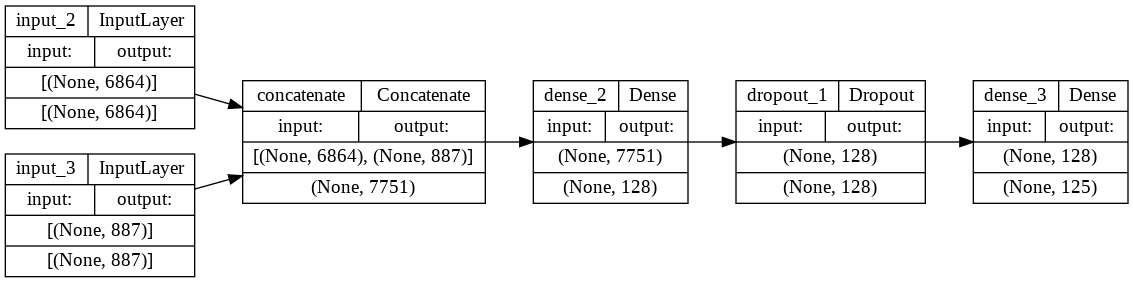

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

This is our first DL model that is receiving two different inputs and concatenating them! See how easy it is to define with the functional API.



In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])


In [ ]:
model.fit(x=[query_train_vec, words_train_vec],
          y=slots_train,
          epochs=epochs
          )

Epoch 1/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.9051 - sparse_categorical_accuracy: 0.7692
Epoch 2/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.3218 - sparse_categorical_accuracy: 0.8825
Epoch 3/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.2407 - sparse_categorical_accuracy: 0.9016
Epoch 4/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.2106 - sparse_categorical_accuracy: 0.9101
Epoch 5/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.1938 - sparse_categorical_accuracy: 0.9134
Epoch 6/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.1831 - sparse_categorical_accuracy: 0.9182
Epoch 7/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9191
Epoch 8/10
1769/1769 [==============================] - 5s 3ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.9215
Epoch 9/10
1769/1769 [==========

In [ ]:
model.evaluate(x=[query_test_vec, words_test_vec], y=slots_test)

288/288 [==============================] - 1s 2ms/step - loss: 0.3307 - sparse_categorical_accuracy: 0.8931


[0.33065924048423767, 0.8931289315223694]

We get to 89% accuracy. Not bad! However, this is a metric across all words, including the 'O's. Since there are so many of them, it could be that our model is overfitting to predict 'O' instead of the actual slots. 

Let's check what the accuracy is for the words that are not 'O' slots:

In [ ]:
from sklearn.metrics import accuracy_score

predicted = np.argmax(model.predict([query_test_vec, words_test_vec]), axis=-1)
actual = np.array([s[0] for s in slots_test])

non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
acc = accuracy_score(actual, predicted)
acc_slots = accuracy_score(actual[actual != non_slot_token], 
                           predicted[actual != non_slot_token])



print(f'Accuracy = {acc:.3f}')
print(f'Accuracy on slots = {acc_slots:.3f}')

Accuracy = 0.893
Accuracy on slots = 0.739


If we restrict ourselves to only look at slots, then the accuracy drops down to 73%. :-(

Think of a search engine that classifies correctly only 73% of its queries. Not good!

Before moving to the next model, let's see how this model does on some examples.

In [ ]:
def predict_slots_query(query):
  words = text_vectorization_word(query.split())
  sentence = text_vectorization_query([query for i in words])

  prediction = np.argmax(model.predict([np.array(sentence), np.array(words)]), axis=-1)
  
  inverse_vocab = dict(enumerate(text_vectorization_slots.get_vocabulary()))
  decoded_prediction = " ".join(inverse_vocab[int(i)] for i in prediction)
  return decoded_prediction

examples = [
            'from los angeles',
            'to los angeles',
            'from boston',
            'to boston',
            'cheapest flight from boston to los angeles tomorrow',
            'what is the airport at orlando',
            'what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars',
            'from boston to santiago'
]

for e in examples:
  print(e)
  print(predict_slots_query(e))
  print()

from los angeles
O B-toloc.city_name I-toloc.city_name

to los angeles
O B-toloc.city_name I-toloc.city_name

from boston
O B-fromloc.city_name

to boston
O B-fromloc.city_name

cheapest flight from boston to los angeles tomorrow
B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_date.today_relative

what is the airport at orlando
O O O O O B-city_name

what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars
O O O O O O O O B-fromloc.city_name O B-toloc.city_name O O O O B-fare_amount I-fare_amount

from boston to santiago
O B-fromloc.city_name O O



In [ ]:
predict_slots_query("i want to fly from New York to Los Angeles tomorrow afternoon")

'O O O O O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_date.today_relative B-depart_time.period_of_day'

In [ ]:
predict_slots_query("YOUR query here!")

We could now try to make the model more complex: increase the number of units or hidden layers, train for more epochs, modify the dropout layer ... 

Instead of going down that path, we will introduce a new architecture that will prove to be much more powerful - **TRANSFORMERS**

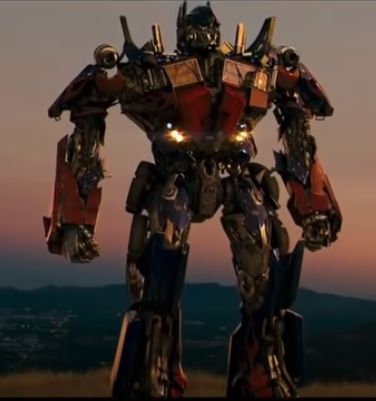

## Transformers





### Explain the attention mechanism




As you’re going through a book, you may be skimming some parts and attentively reading others, depending on what your goals or interests are. What if your models did the same? It’s a simple yet powerful idea: not all input information seen by a model is equally important to the task at hand, so models should “pay more attention” to some features and “pay less attention” to other features.

Does that sound familiar? You’ve already encountered a similar concept twice in this book:

- Max pooling in convnets looks at a pool of features in a spatial region and selects just one feature to keep. That’s an “all or nothing” form of attention: keep the most important feature and discard the rest.
- TF-IDF normalization assigns importance scores to tokens based on how much information different tokens are likely to carry. Important tokens get boosted while irrelevant tokens get faded out. That’s a continuous form of attention.

There are many different forms of attention you could imagine, but they all start by computing importance scores for a set of features, with higher scores for more relevant features and lower scores for less relevant ones. How these scores should be computed, and what you should do with them, will vary from approach to approach.


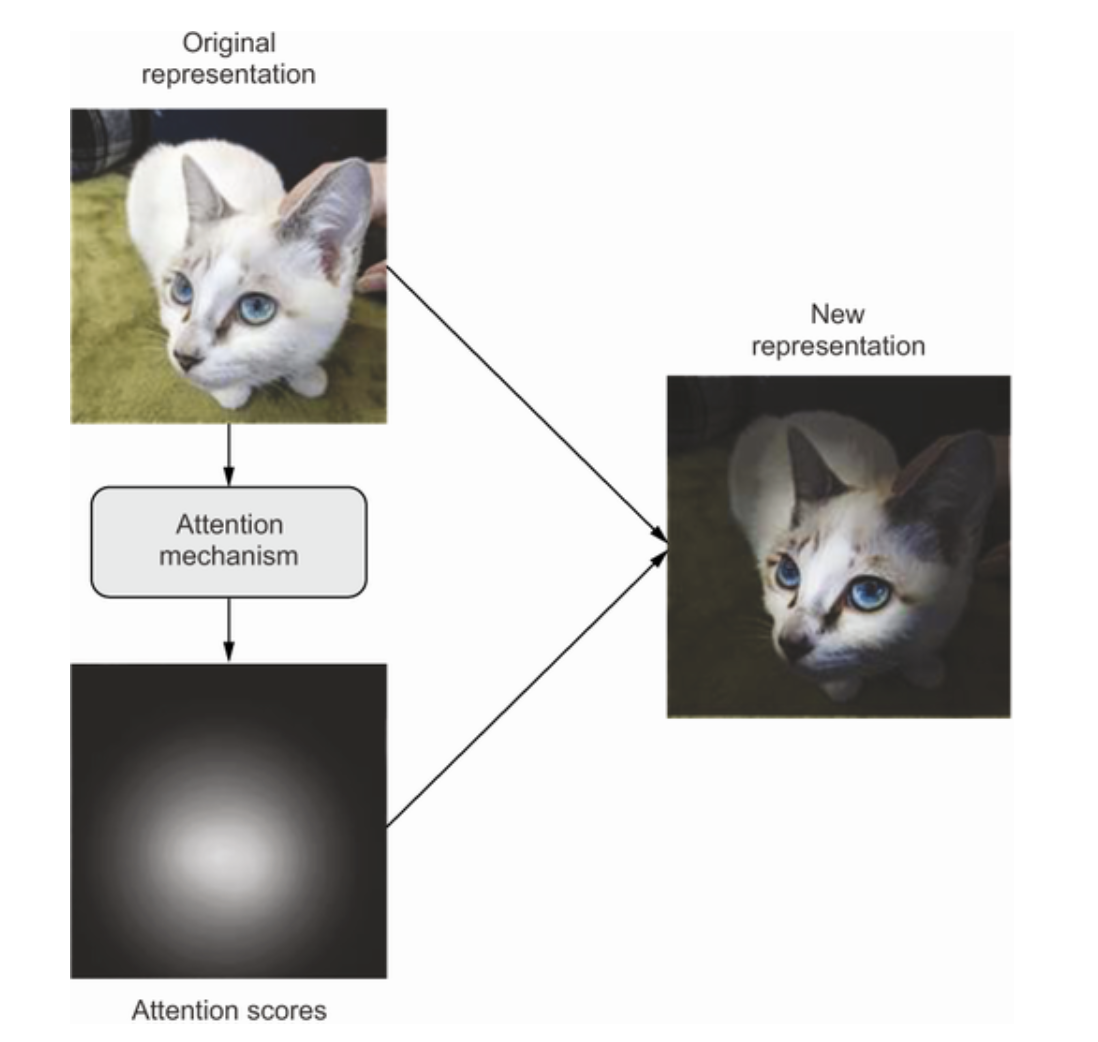

Crucially, this kind of attention mechanism can be used for more than just highlighting or erasing certain features. It can be used to make features context-aware. You’ve just learned about word embeddings—vector spaces that capture the “shape” of the semantic relationships between different words. In an embedding space, a single word has a fixed position—a fixed set of relationships with every other word in the space. But that’s not quite how language works: the meaning of a word is usually context-specific. When you mark the date, you’re not talking about the same “date” as when you go on a date, nor is it the kind of date you’d buy at the market. When you say, “I’ll see you soon,” the meaning of the word “see” is subtly different from the “see” in “I’ll see this project to its end” or “I see what you mean.” And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence-specific and can even change multiple times within a single sentence.

Clearly, a smart embedding space would provide a different vector representation for a word depending on the other words surrounding it. That’s where self-attention comes in. The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context-aware token representations. Consider an example sentence: “The train left the station on time.” Now, consider one word in the sentence: station. What kind of station are we talking about? Could it be a radio station? Maybe the International Space Station? Let’s figure it out algorithmically via self-attention.


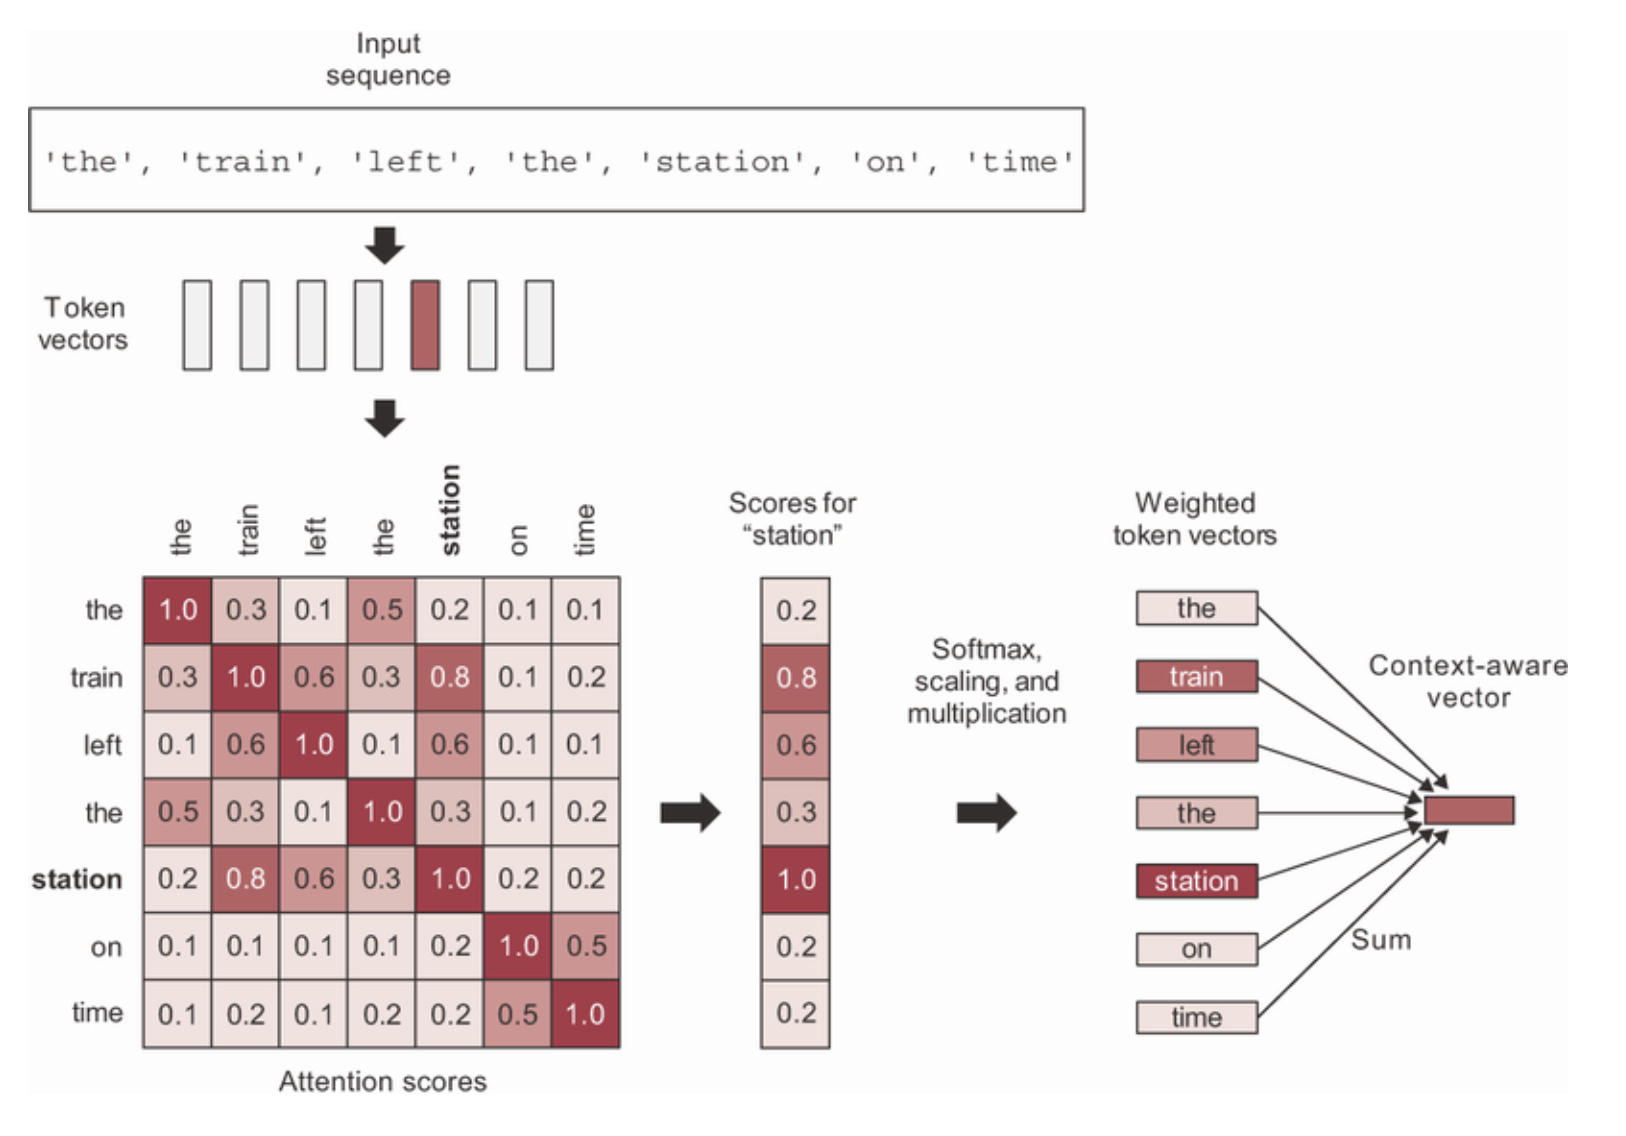



Step 1 is to compute relevancy scores between the vector for “station” and every other word in the sentence. These are our “attention scores.” We’re simply going to use the dot product between two word vectors as a measure of the strength of their relationship. It’s a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. In practice, these scores will also go through a scaling function and a softmax, but for now, that’s just an implementation detail.

Step 2 is to compute the sum of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. The resulting vector is our new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You’d repeat this process for every word in the sentence, producing a new sequence of vectors encoding the sentence.

### Encoder Model



Because the code for transformer encoder architecture is a bit complicated to write, we have decided to package it. This means that you can import it directly from our own "library" (in the same way you do it for Keras layers).


In [ ]:
# Download the "HODL" library
!wget -q 'https://www.dropbox.com/s/4rdgil1epnvgitf/HODL.py'

In [ ]:
# Import the transformer encoder and the positional embedding
from HODL import TransformerEncoder, PositionalEmbedding

In [ ]:
max_query_length = 30

# Textvec of slots
text_vectorization_slots = keras.layers.TextVectorization(
    output_sequence_length=max_query_length,
    standardize=None
)
text_vectorization_slots.adapt(slot_data_train)
slot_vocab_size = text_vectorization_slots.vocabulary_size()

target_train = text_vectorization_slots(slot_data_train)
target_test = text_vectorization_slots(slot_data_test)

# Textvec of query
text_vectorization_query = keras.layers.TextVectorization(
    output_sequence_length=max_query_length
)
text_vectorization_query.adapt(query_data_train)
query_vocab_size = text_vectorization_query.vocabulary_size()

source_train = text_vectorization_query(query_data_train)
source_test = text_vectorization_query(query_data_test)

In [ ]:
# Params
embedding_dim = 512
encoder_units = 64
units = 128
num_heads = 5

# Embedding and Masking
inputs = keras.Input(shape=(max_query_length,))
embedding = PositionalEmbedding(max_query_length, query_vocab_size, embedding_dim)
x = embedding(inputs)
mask = embedding.compute_mask(inputs)

# Transformer Encoding
encoder_out = TransformerEncoder(embedding_dim, encoder_units, num_heads)(x, mask=mask)

# Classifier
x = keras.layers.Dense(units, activation='relu')(encoder_out)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(slot_vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 positional_embedding (Position  (None, 30, 512)     470016      ['input_2[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 30)          0           ['input_2[0][0]']                
                                                                                                  
 transformer_encoder (Transform  (None, 30, 512)     5319232     ['positional_embedding[0][0

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])


In [ ]:
BATCH_SIZE = 64
epochs = 10

# Fit
history = model.fit(source_train, target_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs)

Epoch 1/10
78/78 [==============================] - 6s 26ms/step - loss: 0.4847 - sparse_categorical_accuracy: 0.8989
Epoch 2/10
78/78 [==============================] - 2s 23ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9615
Epoch 3/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9703
Epoch 4/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9788
Epoch 5/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9860
Epoch 6/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9900
Epoch 7/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9922
Epoch 8/10
78/78 [==============================] - 2s 21ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9939
Epoch 9/10
78/78 [==============================] - 2s 2

In [ ]:
# Metrics
def slot_filling_accuracy(actual, predicted, only_slots=False):
  not_padding = np.not_equal(actual, 0) #+ np.not_equal(predicted, 0)

  if only_slots:
    non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
    slots = np.not_equal(actual, non_slot_token)
    correct_predictions = np.equal(actual, predicted)[not_padding * slots]
  else:
    correct_predictions = np.equal(actual, predicted)[not_padding]

  sample_length = len(correct_predictions)

  weights = np.ones(sample_length)

  return np.dot(correct_predictions, weights) / sample_length

predicted = np.argmax(model.predict(source_test), axis=-1).reshape(-1)
actual = target_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy = {acc:.3f}')
print(f'Accuracy on slots = {acc_slots:.3f}')

Accuracy = 0.967
Accuracy on slots = 0.923


Now we get 92% accuracy on the slots and 97% accuracy in general. This is so much better!!

Let's see some examples:

In [ ]:
def predict_slots_query(query):
  sentence = text_vectorization_query([query])

  prediction = np.argmax(model.predict(sentence), axis=-1)[0]
  
  inverse_vocab = dict(enumerate(text_vectorization_slots.get_vocabulary()))
  decoded_prediction = " ".join(inverse_vocab[int(i)] for i in prediction)
  return decoded_prediction

examples = [
            'from los angeles',
            'to los angeles',
            'from boston',
            'to boston',
            'cheapest flight from boston to los angeles tomorrow',
            'what is the airport at orlando',
            'what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars',
            'flight from boston to santiago',
            'flight boston to santiago'
]

for e in examples:
  print(e)
  print(predict_slots_query(e))
  print()

from los angeles
O B-fromloc.city_name I-fromloc.city_name                           

to los angeles
O B-toloc.city_name I-toloc.city_name                           

from boston
O B-fromloc.city_name                            

to boston
O B-toloc.city_name                            

cheapest flight from boston to los angeles tomorrow
B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_date.today_relative                      

what is the airport at orlando
O O O O O B-airport_name                        

what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars
O O O O O O O O B-fromloc.city_name O B-toloc.city_name O O O O B-fare_amount I-fare_amount             

flight from boston to santiago
O O B-fromloc.city_name O B-toloc.city_name                         

flight boston to santiago
O B-fromloc.city_name O B-toloc.city_name                          



Even though 'Santiago' is not a city that is present in the training data set, it is still capable of recognizing it as a destination city name just by context! This is the power of the attention mechanism of transformers.

Can we get even better accuracy if we train for longer? Let's try!

In [ ]:
epochs = 20

# Fit
history = model.fit(source_train, target_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs)

Epoch 1/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9963
Epoch 2/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9969
Epoch 3/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9972
Epoch 4/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9976
Epoch 5/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9975
Epoch 6/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9976
Epoch 7/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9978
Epoch 8/20
78/78 [==============================] - 2s 22ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9980
Epoch 9/20
78/78 [==============================] - 2s 2

In [ ]:
# Metrics
def slot_filling_accuracy(actual, predicted, only_slots=False):
  not_padding = np.not_equal(actual, 0)

  if only_slots:
    non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
    slots = np.not_equal(actual, non_slot_token)
    correct_predictions = np.equal(actual, predicted)[not_padding * slots]
  else:
    correct_predictions = np.equal(actual, predicted)[not_padding]

  sample_length = len(correct_predictions)

  return np.sum(correct_predictions) / sample_length

predicted = np.argmax(model.predict(source_test), axis=-1).reshape(-1)
actual = target_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy = {acc:.3f}')
print(f'Accuracy on slots = {acc_slots:.3f}')

Accuracy = 0.971
Accuracy on slots = 0.931
